# Keyword Spotting for LED Control with TensorFlow Lite for Microcontrollers

This notebook details the design, development, and evaluation of an audio keyword spotting (KWS) system capable of recognizing a small vocabulary of spoken commands. The system is optimized for deployment on resource-constrained microcontrollers (MCUs) using TensorFlow Lite for Microcontrollers (TFLM). In the best run, the final INT8 quantized model achieved ~88% test accuracy with a remarkable size of ~33KB (your results might differ). The goal was to classify short audio commands from a predefined vocabulary of 12 words ([Google Speech Commands v0.0.3](https://tensorflow.google.cn/datasets/catalog/speech_commands]) as processed by TensorFlow Datasets). The recognized commands can then be mapped to control the state and color of RGB LEDs connected to an Arduino Nano 33 BLE Sense MCU.

Full project available on [GitHub](https://github.com/anacletu/tflm-keyword-spotting-led)

**For Kaggle**: This Notebook should run faster when using the GPU accelaration, I used P100.

In [1]:
# Importing the relevant libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Surpressing TF warnings on Kaggle. Comment out if running locally

import random
import librosa

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import Audio, display
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix


2025-06-17 11:02:57.529663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750158177.694786      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750158177.742171      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Checking TensorFlow and GPU availability
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.18.0
Num GPUs Available:  1


In [3]:
# Setting global variables for librosa
N_MFCC = 13  # Number of MFCCs to return
N_FFT = 512 # Length of the FFT window
N_MELS = 40 # Number of Mel bands to generate
HOP_LENGTH = 160 # Number of samples between successive frames
SAMPLE_RATE = 16000 # Sample rate for audio files
WINDOW = 'hann' # Choice of window function
BATCH_SIZE = 64 # Batch size for training
TARGET_FRAMES = int(np.ceil(SAMPLE_RATE / HOP_LENGTH)) # Number of frames to target for each audio sample

In [4]:
# Seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED) # For Python's hash-based operations
random.seed(SEED) # For Python's built-in random module
np.random.seed(SEED) # For NumPy operations
tf.random.set_seed(SEED) # For TensorFlow operations

## Helper Functions

In [5]:
def filter_and_label_example(example_audio, example_label_int):
    """
    Processes audio to float32 and normalizes if original was int16.
    Casts label to int32. 

    Args:
        example_audio: The audio tensor from the dataset.
        example_label_int: The integer label tensor from the dataset (0-11 for v0.0.3).

    Returns:
        A tuple (audio_normalized, label)
    """
    audio = tf.cast(example_audio, tf.float32)

    if example_audio.dtype == tf.int16:
        # Normalize int16 data to the range [-1.0, 1.0]
        audio_normalized = audio / 32768.0
    else:
        audio_normalized = audio

    label = tf.cast(example_label_int, tf.int32)
        
    return audio_normalized, label

In [6]:
def map_fn_train(example, label_key):
    """
    Mapping function to be used with tf.data.Dataset.map().
    Extracts audio and label from the example, and passes them to filter_and_label_example.

    Args:
        example: Dictionary with 'audio' and label tensor.
        label_key: Key used to access the label in the dataset (typically 'label').

    Side Effects:
        Calls filter_and_label_example function
    """
    audio = example['audio']
    label = example[label_key]
    return filter_and_label_example(audio, label)


In [7]:
def sample_class_audio(dataset, class_name, config, num_samples=2):
    """
    Filters a TensorFlow dataset for a specified class and plays a few audio 
    samples from that class using IPython.display.Audio.

    Args:
        dataset (tf.data.Dataset): The input TensorFlow dataset. Expected to yield
            tuples of (audio_tensor, label_tensor), where audio_tensor is 1D
            float32 normalized audio, and label_tensor is a scalar integer.
        class_name (str): The string name of the class to sample (e.g., "on", 
            "_silence_"). Must be a key in `config["label_to_int"]`.
        config (dict): A configuration dictionary containing:
            - "label_to_int" (dict): Mapping string class names to integer labels.
            - "SAMPLE_RATE" (int, optional in this exact function but used by display):
                                    The sample rate of the audio, used by 
                                    IPython.display.Audio. If not in config,
                                    Audio might use a default or fail.
                                    (Your original function implies SAMPLE_RATE is global)
        num_samples (int, optional): The number of audio samples to retrieve
            and play for the class. Defaults to 2.

    Side Effects:
        - Prints descriptive information for each sample.
        - Calls `IPython.display.display(Audio(...))` to play audio samples.

    Raises:
        KeyError: If `class_name` is not found in `config["label_to_int"]`.
        AttributeError: If `dataset` elements don't have a `.numpy()` method.
    """
    class_id = config["label_to_int"][class_name]
    
    # Filter dataset for this class
    class_ds = dataset.filter(lambda audio, label: tf.equal(label, class_id))
    
    # Take a few samples
    for i, (audio, label) in enumerate(class_ds.take(num_samples)):
        print(f"Example {i+1} of class '{class_name}':")
        # Play the audio
        display(Audio(audio.numpy(), rate=SAMPLE_RATE))

In [8]:
def extract_mfccs_tf_py_function(audio_tensor, label_tensor):
    """
    Extracts MFCCs from an audio tensor.
    Assumes audio_tensor is already tf.float32 and normalized.
    Assumes label_tensor is tf.int32.

    Args:
        audio_tensor: A tf.float32 tensor of audio data (normalized). Shape (num_samples,).
        label_tensor: A tf.int32 tensor of the label. Shape ().

    Returns:
        A tuple (mfccs_tensor, label_passthrough_tensor).
    """
    def numpy_mfcc_extractor(audio_tensor_arg, label_tensor_arg):
        # Convert input EagerTensors to NumPy arrays FIRST
        audio_np_for_mfcc = audio_tensor_arg.numpy()
        label_np_for_passthrough = label_tensor_arg.numpy()

        # audio_np_for_mfcc is already float32 normalized from the previous step
        mfccs = librosa.feature.mfcc(y=audio_np_for_mfcc,
                                     sr=SAMPLE_RATE,
                                     n_mfcc=N_MFCC,
                                     n_mels=N_MELS,
                                     n_fft=N_FFT,
                                     hop_length=HOP_LENGTH,
                                     window=WINDOW)
        
        # Adding padding/truncation to ensure consistent output shape
        if mfccs.shape[1] < TARGET_FRAMES:
            # Pad if too short
            padding_width = TARGET_FRAMES - mfccs.shape[1]
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)
        elif mfccs.shape[1] > TARGET_FRAMES:
            # Truncate if too long
            mfccs_padded = mfccs[:, :TARGET_FRAMES]
        else:
            # Already correct length
            mfccs_padded = mfccs

        return mfccs_padded.astype(np.float32), label_np_for_passthrough # Ensure MFCCs are float32

    mfcc_output_shape = (N_MFCC, TARGET_FRAMES)  # Shape of the MFCC output tensor

    mfccs_tensor, label_passthrough_tensor = tf.py_function(
        func=numpy_mfcc_extractor,
        inp=[audio_tensor, label_tensor],
        Tout=(tf.float32, tf.int32) # MFCCs are float32
    )

    # Set the shape for the MFCC tensor
    mfccs_tensor.set_shape(mfcc_output_shape)
    # Set the shape for the label tensor (should be scalar)
    if label_tensor.shape == tf.TensorShape([]):
        label_passthrough_tensor.set_shape([])
    else:
        label_passthrough_tensor.set_shape(label_tensor.shape)

    return mfccs_tensor, label_passthrough_tensor

In [9]:
def create_cnn_model(input_shape, num_classes):
    """
    Creates and returns a Keras Sequential Convolutional Neural Network (CNN) 
    model tailored for audio keyword spotting using MFCC-like features.

    The architecture consists of three convolutional blocks followed by
    Global Average Pooling and two dense layers for classification.
    Dropout is included for regularization.

    Args:
        input_shape (tuple): The shape of the input features for a single sample,
            excluding the batch dimension. For MFCCs, this is typically 
            (num_mfcc_features, num_frames, num_channels), 
            e.g., (13, 100, 1).
        num_classes (int): The number of distinct classes the model needs to
            predict (e.g., 12 for the keyword spotting task). This determines
            the number of units in the final softmax output layer.

    Returns:
        keras.Model: A compiled Keras Sequential model instance, ready for
            training (though compilation with optimizer, loss, and metrics
            needs to be done separately after calling this function).
    """
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape, name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.1, name='dropout1'),

        # Block 2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.15, name='dropout2'),

        # Block 3
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.Dropout(0.2, name='dropout3'), # Dropout after the last convolutional layer

        layers.GlobalAveragePooling2D(name='global_avg_pool'),
        layers.Dropout(0.3, name='dropout_gap'), # Dropout after GAP

        layers.Dense(32, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout_dense1'), # Dropout after the dense layer

        layers.Dense(num_classes, activation='softmax', name='output_softmax') # Output layer
    ])
    return model

## Dataset Exploration ([Google Speech Commands v0.0.3](https://tensorflow.google.cn/datasets/catalog/speech_commands]))

### Loading and Preparing
**Important**: This section might take a long time depending on your connection speed. If running on Kaggle, it might take over an hour, so make sure to enable file persistence to avoid redownload in between sessions. 

In [10]:
# Loading the speech_commands dataset (version 0.0.3) from TensorFlow Datasets
# This version contains 12 classes, including 'unknown' and 'silence'.
# The dataset is split into training, validation, and test sets.

# Defining the path for the dataset
# DATA_PATH = os.path.join("..", "data", "raw", "tensorflow_datasets") # UNCOMMENT if running locally
DATA_PATH = '/kaggle/working/data' # For Kaggle. COMMENT if running locally
os.makedirs(DATA_PATH, exist_ok=True)

try:
    builder = tfds.builder("speech_commands:0.0.3")
    builder.download_and_prepare(download_dir=DATA_PATH)
    ds_train_full, ds_info = tfds.load('speech_commands', split='train', with_info=True, shuffle_files=True, data_dir=DATA_PATH)
    ds_val_full = tfds.load('speech_commands', split='validation', shuffle_files=False, data_dir=DATA_PATH)
    ds_test_full = tfds.load('speech_commands', split='test', shuffle_files=False, data_dir=DATA_PATH)

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e # Stop execution if dataset loading fails

# Displaying the dataset information if successfully loaded
print("\nDataset Information (ds_info):")
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.HBRPOI_0.0.3/speech_commands-train.tfrecord*...…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.HBRPOI_0.0.3/speech_commands-validation.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.HBRPOI_0.0.3/speech_commands-test.tfrecord*...:…

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /kaggle/working/data/speech_commands/incomplete.G8F1CB_0.0.3/speech_commands-train.tfrecord*...:   0…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /kaggle/working/data/speech_commands/incomplete.G8F1CB_0.0.3/speech_commands-validation.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /kaggle/working/data/speech_commands/incomplete.G8F1CB_0.0.3/speech_commands-test.tfrecord*...:   0%…

Dataset speech_commands downloaded and prepared to /kaggle/working/data/speech_commands/0.0.3. Subsequent calls will reuse this data.


I0000 00:00:1750166206.744203      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Dataset Information (ds_info):
tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """

In [11]:
# Checking the features in the dataset
print("\nFeatures:")
print(ds_info.features)

# Label key for the dataset
label_key = 'label'

# Classes in the dataset
num_total_classes = ds_info.features[label_key].num_classes
print(f"\nTotal number of classes in the dataset: {num_total_classes}")

# String names of the classes
class_names_full = ds_info.features[label_key].names
print(f"\nFull list of class names:")
print(class_names_full)

# Number of examples in each split
print(f"\nNumber of examples in train split: {ds_info.splits['train'].num_examples}")
print(f"Number of examples in validation split: {ds_info.splits['validation'].num_examples}")
print(f"Number of examples in test split: {ds_info.splits['test'].num_examples}")

# Audio sample rate
SAMPLE_RATE = ds_info.features['audio'].sample_rate
print(f"\nSample rate: {SAMPLE_RATE} Hz")


Features:
FeaturesDict({
    'audio': Audio(shape=(None,), dtype=int16),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=12),
})

Total number of classes in the dataset: 12

Full list of class names:
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Number of examples in train split: 85511
Number of examples in validation split: 10102
Number of examples in test split: 4890

Sample rate: 16000 Hz



--- Single Example ---
Audio data shape: (16000,)
Audio data type: int16
Min audio value: -13647, Max audio value: 15375
Integer label: 0
String label: down


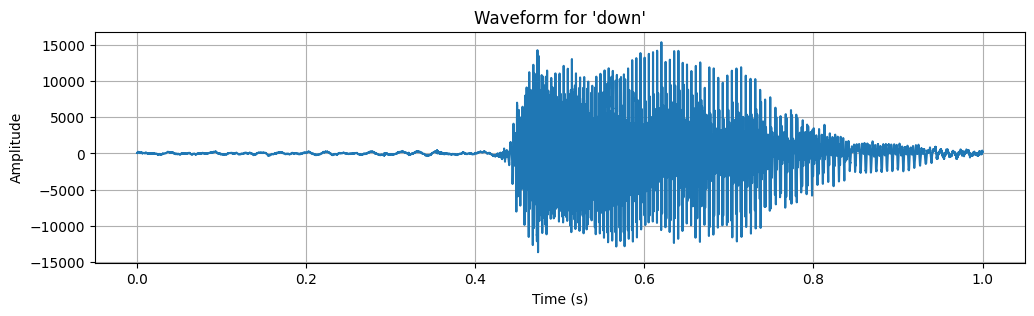


MFCCs shape: (13, 101)


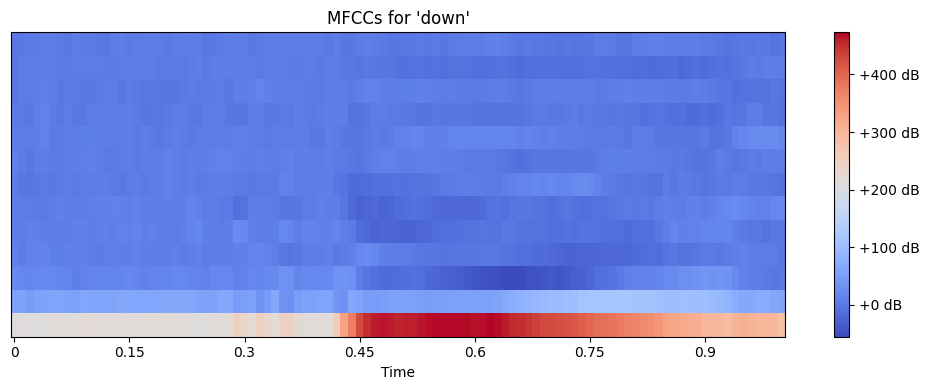

In [12]:
# Checking one random example from the training dataset for visualization
for example in ds_train_full.take(1):
    audio_data = example['audio'].numpy()
    label_int = example[label_key].numpy()
    label_str = class_names_full[label_int]

    print(f"\n--- Single Example ---")
    print(f"Audio data shape: {audio_data.shape}") 
    print(f"Audio data type: {audio_data.dtype}")
    print(f"Min audio value: {np.min(audio_data)}, Max audio value: {np.max(audio_data)}")
    print(f"Integer label: {label_int}")
    print(f"String label: {label_str}")

    # Visualizing the waveform
    plt.figure(figsize=(12, 3))
    plt.plot(np.linspace(0, len(audio_data) / SAMPLE_RATE, num=len(audio_data)), audio_data)
    plt.title(f"Waveform for '{label_str}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Audio playback for testing
    display(Audio(audio_data, rate=SAMPLE_RATE, autoplay=True))
    
    # Ensure audio_data is float for librosa
    mfccs = librosa.feature.mfcc(y=audio_data.astype(float),
                                 sr=SAMPLE_RATE,
                                 n_mfcc=N_MFCC,
                                 n_mels=N_MELS,
                                 n_fft=N_FFT,
                                 hop_length=HOP_LENGTH,
                                 window=WINDOW)

    print(f"\nMFCCs shape: {mfccs.shape}") # (n_mfcc, n_frames)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB') # Colorbar shows decibels
    plt.title(f"MFCCs for '{label_str}'")
    plt.tight_layout()
    plt.show()

# Cleaning up
del example, audio_data, label_int, label_str, mfccs

In [13]:
# 1. Define the labels the MODEL will learn and predict.
config = {}
num_classes = ds_info.features[label_key].num_classes
config["all_model_labels"] = class_names_full
print(f"All labels the model will learn (all_model_labels): {config['all_model_labels']}")
print(f"Number of classes model will predict: {num_classes}") 

# 2. Create mappings for these model labels
config["label_to_int"] = {label: i for i, label in enumerate(config["all_model_labels"])}
config["int_to_label"] = {i: label for i, label in enumerate(config["all_model_labels"])} 
print(f"\nLabel to int mapping for model: {config['label_to_int']}")
print(f"Int to label mapping for model: {config['int_to_label']}")

All labels the model will learn (all_model_labels): ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']
Number of classes model will predict: 12

Label to int mapping for model: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'up': 8, 'yes': 9, '_silence_': 10, '_unknown_': 11}
Int to label mapping for model: {0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'stop', 8: 'up', 9: 'yes', 10: '_silence_', 11: '_unknown_'}


### Testing the Audio Normalizaton and Mapping Functions
This section verifies the initial audio processing steps: casting raw audio to float32, normalizing its range, and ensuring labels are correctly passed through or mapped before feature extraction.

**Note on Audio Samples**: The Speech Commands dataset was crowdsourced, leading to variability in recording quality and pronunciation across samples. This is a factor to consider when evaluating model performance and listening to individual audio clips.

In [14]:
# Test Case 1: A word that is one of the 10 core commands
test_word_core_command = "on"
n_iterations = 2000 # Iterate enough to find it

print(f"\n--- Testing with a core command: '{test_word_core_command}' ---")
found_core_command = False
for ex in ds_train_full.take(n_iterations): 
    # Get the original string label from the dataset
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_word_core_command:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )

        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}")
        print(f"Processed model label int: {processed_label_int}")
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_core_command = True
        
        # Audio playback for testing
        display(Audio(processed_audio_tensor.numpy(), rate=SAMPLE_RATE, autoplay=True))
        break

if not found_core_command:
    print(f"Could not find an example of '{test_word_core_command}' in the first {n_iterations} samples of ds_train_full.")

# Cleaning up
del ex, original_dataset_label_str, processed_audio_tensor, processed_label_int_tensor, processed_label_int



--- Testing with a core command: 'on' ---
Original dataset label string: 'on'
Original dataset label int: 5
Processed model label int: 5
Processed model label string (from config['int_to_label']): on


In [15]:
# Test Case 2: An example that TFDS v0.0.3 labels as '_unknown_'
test_dataset_label_is_unknown = "_unknown_" 

print(f"\n--- Testing with an example labeled as '{test_dataset_label_is_unknown}' by the dataset ---")
found_unknown_example = False
for ex in ds_train_full.take(n_iterations): 
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_dataset_label_is_unknown:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )
        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}") # Should be index of '_unknown_'
        print(f"Processed model label int: {processed_label_int}")   # Should be the same index
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_unknown_example = True

        # Audio playback for testing
        display(Audio(processed_audio_tensor.numpy(), rate=SAMPLE_RATE, autoplay=True))
        break
if not found_unknown_example:
    print(f"Could not find an example labeled as '{test_dataset_label_is_unknown}' in the first {n_iterations} samples of ds_train_full.")

# Cleaning up
del ex, original_dataset_label_str, processed_audio_tensor, processed_label_int_tensor, processed_label_int


--- Testing with an example labeled as '_unknown_' by the dataset ---
Original dataset label string: '_unknown_'
Original dataset label int: 11
Processed model label int: 11
Processed model label string (from config['int_to_label']): _unknown_


In [16]:
# Test Case 3: An example labeled as '_silence_' by the dataset
test_dataset_label_is_silence = "_silence_"

print(f"\n--- Testing with an example labeled as '{test_dataset_label_is_silence}' by the dataset ---")
found_silence_example = False
for ex in ds_train_full.take(n_iterations): 
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_dataset_label_is_silence:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )
        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}")
        print(f"Processed model label int: {processed_label_int}")
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_silence_example = True

        # Audio playback for testing
        display(Audio(processed_audio_tensor.numpy(), rate=SAMPLE_RATE, autoplay=True))
        break
if not found_silence_example:
    print(f"Could not find an example labeled as '{test_dataset_label_is_silence}' in the first {n_iterations} samples of ds_train_full.")

# Cleaning up
del ex, original_dataset_label_str, processed_audio_tensor, processed_label_int_tensor, processed_label_int


--- Testing with an example labeled as '_silence_' by the dataset ---
Original dataset label string: '_silence_'
Original dataset label int: 10
Processed model label int: 10
Processed model label string (from config['int_to_label']): _silence_


In [17]:
# Wrap the map function with predefined arguments
map_fn = partial(map_fn_train, label_key=label_key)

# Apply the mapping
ds_train_mapped = ds_train_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_mapped = ds_val_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_mapped = ds_test_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

## Class Imbalance

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


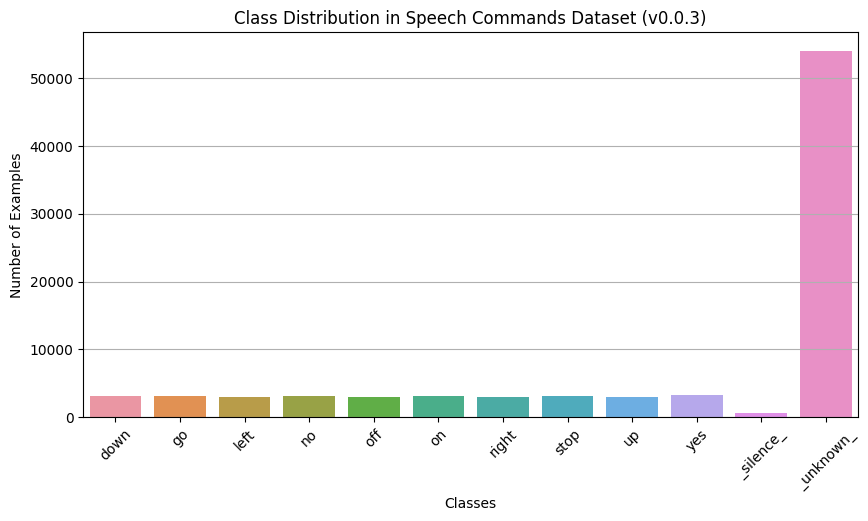

In [18]:
# Visualization of class distribution in the dataset
class_counts = np.zeros(num_classes, dtype=int)
for _, label in ds_train_mapped:
    class_counts[label.numpy()] += 1

plt.figure(figsize=(10, 5))
sns.barplot(x=config["all_model_labels"], y=class_counts)
plt.title("Class Distribution in Speech Commands Dataset (v0.0.3)")
plt.xlabel("Classes")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [19]:
# Preparing the dataset for resampling
# Create separate datasets for each class
ds_unknown = ds_train_mapped.filter(
    lambda audio, label: tf.equal(label, config["label_to_int"]["_unknown_"])
)
ds_silence = ds_train_mapped.filter(
    lambda audio, label: tf.equal(label, config["label_to_int"]["_silence_"])
)
ds_others = ds_train_mapped.filter(
    lambda audio, label: tf.logical_and(
        tf.not_equal(label, config["label_to_int"]["_unknown_"]),
        tf.not_equal(label, config["label_to_int"]["_silence_"])
    )
)

# Undersample _unknown_ class
ds_unknown_sampled = ds_unknown.take(10000) # You can experiment with the amount. I decided to undersample to 10k examples.

# Oversample _silence_ class
ds_silence_oversampled = ds_silence.repeat(2) # Repeating only 2 to avoid overfitting. You can experiment as well.

# Calculate balanced dataset size
ds_size = 0
for _ in ds_others.concatenate(ds_unknown_sampled).concatenate(ds_silence_oversampled):
    ds_size += 1

# Combine datasets and shuffle
ds_train_mapped_balanced = ds_others.concatenate(ds_unknown_sampled).concatenate(ds_silence_oversampled)
ds_train_mapped_balanced = ds_train_mapped_balanced.shuffle(ds_size, seed=SEED)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


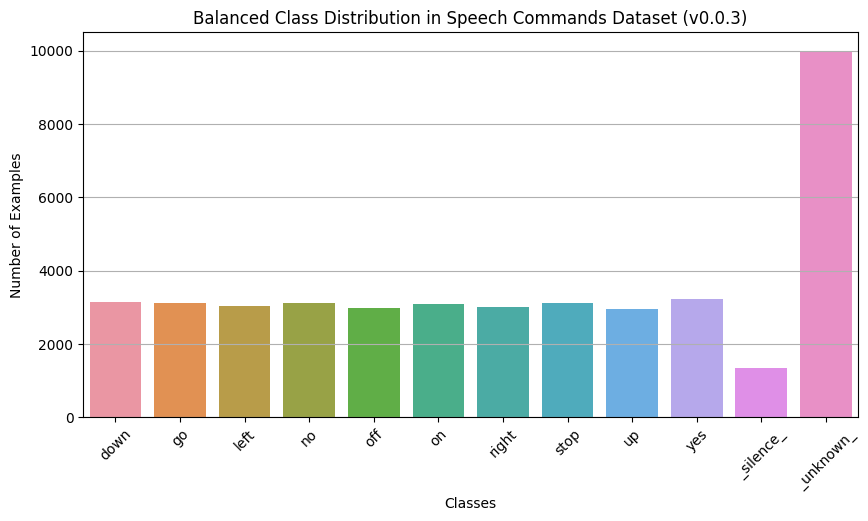

In [20]:
# Visualizing class distribution after balancing
class_counts_balanced = np.zeros(num_classes, dtype=int)
for _, label in ds_train_mapped_balanced:
    class_counts_balanced[label.numpy()] += 1
plt.figure(figsize=(10, 5))
sns.barplot(x=config["all_model_labels"], y=class_counts_balanced)
plt.title("Balanced Class Distribution in Speech Commands Dataset (v0.0.3)")
plt.xlabel("Classes")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Note on Audio Sample Quality**: When listening to individual samples from the Speech Commands dataset (especially from the _unknown_ or rebalanced categories), you may encounter audio clips with varying recording quality or non-standard utterances. The dataset was crowdsourced, and while comprehensive, this can lead to a diversity in recording conditions and articulation. This inherent variability in the source data naturally influences the upper bound of achievable model accuracy.

In [21]:
# Sample and play examples from the balanced dataset to make sure everything worked as expected
print("\n--- Sampling Audio Examples from Balanced Dataset ---")

# Sample examples of regular commands
for keyword in ["up", "down", "on", "off"]:
    if keyword in config["all_model_labels"]:
        sample_class_audio(ds_train_mapped_balanced, keyword, config, num_samples=1)

# Sample examples of special classes
sample_class_audio(ds_train_mapped_balanced, "_unknown_", config, num_samples=1)
sample_class_audio(ds_train_mapped_balanced, "_silence_", config, num_samples=1)


--- Sampling Audio Examples from Balanced Dataset ---
Example 1 of class 'up':


Example 1 of class 'down':


Example 1 of class 'on':


Example 1 of class 'off':


Example 1 of class '_unknown_':


Example 1 of class '_silence_':


## Feature Extraction (MFCCs) and Final Dataset Preparation

### MFCC Feature Extraction


--- Testing MFCC Extraction ---
Original audio shape: (16000,), Original label: 0
MFCC features shape: (13, 100)
Label after MFCC: 0


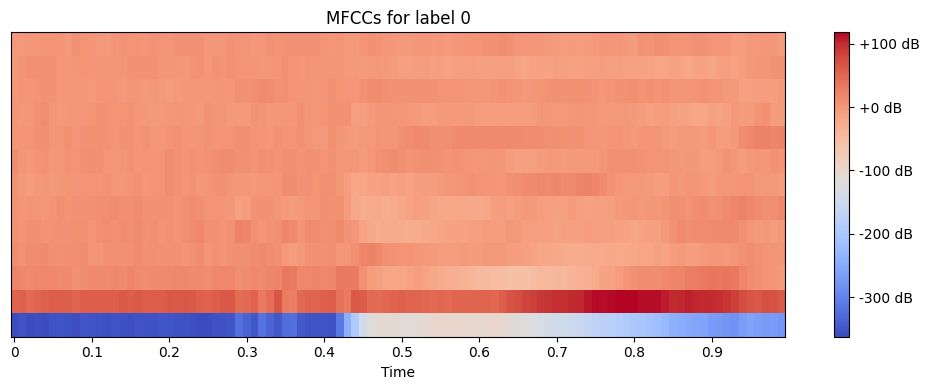

In [22]:
# Testing the MFCC extraction function
print("\n--- Testing MFCC Extraction ---")
for audio_sample, label_sample in ds_train_mapped.take(1):
    print(f"Original audio shape: {audio_sample.shape}, Original label: {label_sample.numpy()}")
    mfcc_features, label_after_mfcc = extract_mfccs_tf_py_function(audio_sample, label_sample)
    print(f"MFCC features shape: {mfcc_features.shape}") # Should be (N_MFCC, num_frames_calculated)
    print(f"Label after MFCC: {label_after_mfcc.numpy()}")
    
    # Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc_features.numpy(), # Convert to numpy for plotting
                             sr=SAMPLE_RATE,
                             hop_length=HOP_LENGTH,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"MFCCs for label {label_after_mfcc.numpy()}")
    plt.tight_layout()
    plt.show()

    # Audio playback for testing
    display(Audio(audio_sample.numpy(), rate=SAMPLE_RATE, autoplay=True))
    break

# Cleaning up
del audio_sample, label_sample, mfcc_features, label_after_mfcc

In [23]:
# Applying the MFCC extraction function to the datasets
ds_train_features = ds_train_mapped_balanced.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_features = ds_val_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_features = ds_test_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)

# Check the first element of the new dataset
print("\n--- First example from dataset with MFCC features ---")
for mfcc_ex, label_ex in ds_train_features.take(1):
    print(f"MFCC example shape: {mfcc_ex.shape}, Label: {label_ex.numpy()}")


--- First example from dataset with MFCC features ---
MFCC example shape: (13, 100), Label: 0


### Preparing Individual Samples for Serial Testing

This section details the process of extracting and saving individual preprocessed MFCC samples (as .npy files) from the test dataset. These saved samples are then used by a companion Python script (utils/send_mfcc_to_arduino.py) to send feature data to the microcontroller (MCU) for on-device inference testing.

- **Note for Kaggle Users**: This step is primarily for local MCU interaction. If running this notebook solely on Kaggle for model training and evaluation, this specific sample-saving section can be skipped.
- For the complete project including the Python sender script and Arduino firmware, please refer to the full [GitHub repository](https://github.com/anacletu/tflm-keyword-spotting-led).

Uncomment if **running locally** and if you plan to deploy the model.

In [24]:
# # Adding a channel dimension for CNN input
# ds_test_individual_samples_with_channel = ds_test_features.map(
#     lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

# # Cache the dataset to speed up subsequent operations
# test_sender_cache_file = os.path.join('.tf_cache/', "test_individual_for_sender_cache")
# ds_test_for_sender_source = ds_test_individual_samples_with_channel.cache(filename=test_sender_cache_file)

# print("`ds_test_for_sender_source` is ready. It yields individual processed MFCCs with channel.")


# # --- Save some samples from ds_test_for_sender_source for the Python sender script ---
# samples_to_save = {
#     "on": None,
#     "off": None,
#     "up": None, # Example for red
#     "down": None, # Example for blue
#     "right": None, # Example for green
#     "left": None,
#     "_silence_": None,
#     "_unknown_": None
# }
# num_to_find_each = 1 # Save one of each

# # Make sure the 'test_samples_for_arduino' directory exists
# SAMPLES_DIR = '../utils/test_samples_for_arduino'
# os.makedirs(SAMPLES_DIR, exist_ok=True)

# # Iterate through the dataset to find and save one instance of each desired label
# # Shuffle to get different samples if run multiple times
# temp_ds_for_saving = ds_test_for_sender_source.shuffle(1000, seed=None) 

# found_counts = {key: 0 for key in samples_to_save}

# print(f"Searching for and saving specific samples to '{SAMPLES_DIR}/'...")
# for mfcc_HWC_tensor, label_tensor in temp_ds_for_saving.take(2000): # Search within first 2000 samples
#     label_int = label_tensor.numpy()
#     label_str = config['int_to_label'].get(label_int, "ERROR_UNKNOWN_LABEL_INT")

#     if label_str in samples_to_save and found_counts[label_str] < num_to_find_each:
#         sample_np = mfcc_HWC_tensor.numpy()
#         filename = os.path.join(SAMPLES_DIR, f"sample_mfcc_{label_str}.npy")
#         np.save(filename, sample_np)
#         print(f"Saved: {filename} (shape: {sample_np.shape}, label: {label_str})")
#         samples_to_save[label_str] = "saved" # Mark as found and saved
#         found_counts[label_str] += 1
#         # Check if all desired samples are found
#         if all(count >= num_to_find_each for count in found_counts.values()):
#             break
# print("Sample saving complete.")

### Cache, Shuffle, and Batch the Datasets


In [25]:
# Caching the TRAINING dataset for performance
CACHE_DIR = os.path.join(os.getcwd(), ".tf_cache") # In current notebook dir, hidden folder
os.makedirs(CACHE_DIR, exist_ok=True) # Create directory if it doesn't exist

train_cache_file = os.path.join(CACHE_DIR, "train_mfcc_cache")
val_cache_file = os.path.join(CACHE_DIR, "val_mfcc_cache")
test_cache_file = os.path.join(CACHE_DIR, "test_mfcc_cache")

print("Preparing ds_train...")
ds_train_intermediate = ds_train_features.cache(filename=train_cache_file) # Cache the training dataset
print(f"Cached ds_train to {train_cache_file}")

# Calculate the number of elements in the training dataset for the shuffle buffer
print("Calculating shuffle buffer size for ds_train...")
SHUFFLE_BUFFER_SIZE = 0
for _ in ds_train_intermediate:
    SHUFFLE_BUFFER_SIZE += 1
print(f"Calculated SHUFFLE_BUFFER_SIZE for ds_train: {SHUFFLE_BUFFER_SIZE}")

# Now apply shuffle, batch, prefetch
ds_train = ds_train_intermediate.shuffle(SHUFFLE_BUFFER_SIZE, seed=SEED, reshuffle_each_iteration=True)
ds_train = ds_train.repeat()
ds_train = ds_train.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
print("ds_train preparation complete.")


Preparing ds_train...
Cached ds_train to /kaggle/working/.tf_cache/train_mfcc_cache
Calculating shuffle buffer size for ds_train...
Calculated SHUFFLE_BUFFER_SIZE for ds_train: 42105
ds_train preparation complete.


In [26]:
# Prepare the VALIDATION dataset
print("\nPreparing ds_val...")
ds_val = ds_val_features.cache(filename=val_cache_file) # Cache the validation dataset
print(f"Cached ds_val to {val_cache_file}")
ds_val = ds_val.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)
print("ds_val preparation complete.")


Preparing ds_val...
Cached ds_val to /kaggle/working/.tf_cache/val_mfcc_cache
ds_val preparation complete.


In [27]:
# Prepare the TEST dataset
print("\nPreparing ds_test...")
ds_test = ds_test_features.cache(filename=test_cache_file) # Cache the test dataset
print(f"Cached ds_test to {test_cache_file}")
ds_test = ds_test.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
print("ds_test preparation complete.")


Preparing ds_test...
Cached ds_test to /kaggle/working/.tf_cache/test_mfcc_cache
ds_test preparation complete.


In [28]:
# Verify the output of one batch from the prepared training data
print("\n--- Shape of one batch from final processed training data (ds_train) ---")
for mfcc_batch, label_batch in ds_train.take(1):
    print(f"MFCC batch shape: {mfcc_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Data type of MFCC batch: {mfcc_batch.dtype}")
    print(f"Data type of Label batch: {label_batch.dtype}")
    break

print("\n--- Shape of one batch from final processed validation data (ds_val) ---")
for mfcc_batch_val, label_batch_val in ds_val.take(1):
    print(f"MFCC batch shape (validation): {mfcc_batch_val.shape}")
    print(f"Label batch shape (validation): {label_batch_val.shape}")
    break

print("\n--- Shape of one batch from final processed test data (ds_test) ---")
for mfcc_batch_test, label_batch_test in ds_test.take(1):
    print(f"MFCC batch shape (test): {mfcc_batch_test.shape}")
    print(f"Label batch shape (test): {label_batch_test.shape}")
    break

print("\nDataset preparation complete for training, validation, and testing!")


--- Shape of one batch from final processed training data (ds_train) ---
MFCC batch shape: (64, 13, 100, 1)
Label batch shape: (64,)
Data type of MFCC batch: <dtype: 'float32'>
Data type of Label batch: <dtype: 'int32'>

--- Shape of one batch from final processed validation data (ds_val) ---
MFCC batch shape (validation): (64, 13, 100, 1)
Label batch shape (validation): (64,)

--- Shape of one batch from final processed test data (ds_test) ---
MFCC batch shape (test): (64, 13, 100, 1)
Label batch shape (test): (64,)

Dataset preparation complete for training, validation, and testing!


In [29]:
# Determine input shape for the model
input_shape_for_model = (N_MFCC, TARGET_FRAMES, 1) # (height, width, channels)
print(f"Input shape for the model: {input_shape_for_model}")

# Number of output classes
print(f"Number of output classes: {num_classes}")

Input shape for the model: (13, 100, 1)
Number of output classes: 12


## Defining the CNN Model

In [30]:
# Create the model instance
model = create_cnn_model(input_shape_for_model, num_classes)

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 13, 100, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 6, 50, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 6, 50, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 6, 50, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 3, 25, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 3, 25, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 3, 25, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 3, 25, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool                      │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_gap (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense1 (Dropout)             │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax (Dense)               │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,772 (100.67 KB)

 Trainable params: 25,772 (100.67 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), # LR accuracy
    loss='sparse_categorical_crossentropy', # For multi-class classification with integer labels
    metrics=['accuracy'] # Track accuracy during training
)
print("Model compiled successfully.")

Model compiled successfully.


## Training the CNN Model

In [32]:
# ModelCheckpoint: Save the model or weights at some frequency.
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras', # Keras v3 native format
    save_weights_only=False,    # Save the full model
    monitor='val_accuracy',     # Monitor validation accuracy
    mode='max',                 # Mode for val_accuracy should be 'max'
    save_best_only=True         # Only save if 'val_accuracy' has improved
)

# EarlyStopping: Stop training when a monitored metric has stopped improving.
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min',                 # Mode for val_loss should be 'min'
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity.
)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001, # Lower bound on the learning rate.
    verbose=1,
    mode='min'
)

callbacks_list = [
    model_checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback
]

In [33]:
# Fitting the model 
EPOCHS = 100 # EarlyStopping might stop it sooner.

print("\n--- Starting Model Training ---")
history = model.fit(
    ds_train,                   # Prepared training dataset
    epochs=EPOCHS,
    validation_data=ds_val,     # Prepared validation dataset
    callbacks=callbacks_list,    # Pass the list of callbacks
    steps_per_epoch= SHUFFLE_BUFFER_SIZE // BATCH_SIZE,
)
print("--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/100


I0000 00:00:1750166905.582674      95 service.cc:148] XLA service 0x78957800fed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750166905.584157      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750166905.932643      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 45/657 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0646 - loss: 14.8258

I0000 00:00:1750166909.736627      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.0973 - loss: 5.2326 - val_accuracy: 0.6211 - val_loss: 2.3084 - learning_rate: 1.0000e-04
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1968 - loss: 2.4146 - val_accuracy: 0.6216 - val_loss: 2.1813 - learning_rate: 1.0000e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2310 - loss: 2.3467 - val_accuracy: 0.6209 - val_loss: 2.0124 - learning_rate: 1.0000e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2350 - loss: 2.2747 - val_accuracy: 0.6228 - val_loss: 1.7955 - learning_rate: 1.0000e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2494 - loss: 2.1860 - val_accuracy: 0.6132 - val_loss: 1.6828 - learning_rate: 1.0000e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2706 - loss: 2.1031 - val_accuracy: 0.6159 - val_loss: 1.5925 - learning_rate: 1.0000e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2


--- Plotting Training History ---


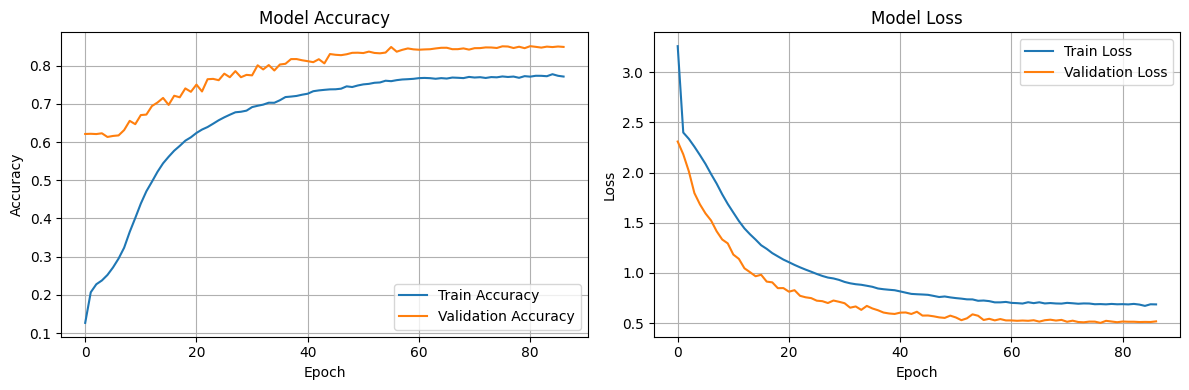

In [34]:
print("\n--- Plotting Training History ---")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluating the Model on Unseen Data

In [35]:
# Model Evaluation
print("\n--- Evaluating Model on Test Set ---")

try:
    print("\nLoading 'best_model.keras' saved by ModelCheckpoint (based on val_accuracy)...")
    best_model_on_val_acc = keras.models.load_model('best_model.keras')
    print("Model loaded successfully.")

    test_loss_best_val_acc, test_accuracy_best_val_acc = best_model_on_val_acc.evaluate(ds_test, verbose=1)
    print(f"\nTest Loss (from best_model.keras based on val_accuracy): {test_loss_best_val_acc:.4f}")
    print(f"Test Accuracy (from best_model.keras based on val_accuracy): {test_accuracy_best_val_acc:.4f}")
except Exception as e:
    print(f"Could not load or evaluate 'best_model.keras': {e}")
    print("Continuing with the model from EarlyStopping.")


--- Evaluating Model on Test Set ---

Loading 'best_model.keras' saved by ModelCheckpoint (based on val_accuracy)...
Model loaded successfully.
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.8514 - loss: 0.4991

Test Loss (from best_model.keras based on val_accuracy): 0.5010
Test Accuracy (from best_model.keras based on val_accuracy): 0.8556


**Note on Model Performance and Reproducibility**:

The primary Keras model referenced in this project (and used for TFLite conversion) achieved approximately 88% test accuracy with a validation loss around 0.47 during its training run.
Due to the stochastic nature of machine learning training (including differences in random weight initialization, data shuffling order even with set seeds across different hardware/software environments, and minor variations in floating-point arithmetic), re-running this notebook locally may yield slightly different performance metrics (e.g., validation/test accuracy, loss values).

The provided code aims for reproducibility by setting random seeds. If you train a new model locally and follow the complete pipeline, the filenames for saved models (e.g., in the models/ directory or for TFLite files) will incorporate the new accuracy achieved, as some saving steps use Python f-strings to include performance metrics in the name (e.g., final_model_test_acc_{accuracy:.2f}.keras).

## Predictions and Evaluation

In [36]:
# Predictions 
print("\n--- Generating Predictions ---")
y_pred_probs = best_model_on_val_acc.predict(ds_test) # Get probability scores for each class
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability

# Get true labels from the test set
y_true = []
for _, labels_batch in ds_test: # ds_test yields (mfcc_batch, label_batch)
    y_true.extend(labels_batch.numpy())
y_true = np.array(y_true)

# Ensure shapes match (number of predictions should equal number of true labels)
print(f"Shape of y_pred_classes: {y_pred_classes.shape}")
print(f"Shape of y_true: {y_true.shape}")

if len(y_pred_classes) != len(y_true):
    print("Warning: Mismatch in number of predictions and true labels. Confusion matrix might be incorrect.")
    # This can happen if ds_test was not fully iterated or if batching caused issues with the last batch.
    min_len = min(len(y_pred_classes), len(y_true))
    y_pred_classes = y_pred_classes[:min_len]
    y_true = y_true[:min_len]
    print(f"Adjusted shapes to: y_pred_classes: {y_pred_classes.shape}, y_true: {y_true.shape}")


--- Generating Predictions ---
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Shape of y_pred_classes: (4890,)
Shape of y_true: (4890,)


In [37]:
# Classification Report (Precision, Recall, F1-score)
if 'config' in locals() and 'all_model_labels' in config:
    report_target_names = config["all_model_labels"]
    # Ensure labels in y_true and y_pred_classes are within the range of report_target_names indices
    max_label_val = max(np.max(y_true), np.max(y_pred_classes))
    if max_label_val >= len(report_target_names):
        print(f"Warning: Max label value ({max_label_val}) exceeds number of target names ({len(report_target_names)}). Report might be misaligned.")
        # Create generic target names if misalignment is suspected
        report_target_names = [f"Class {i}" for i in range(max_label_val + 1)]


    print("\nClassification Report:")
    # Ensure y_true and y_pred_classes contain integer labels [0, num_classes-1]
    # Also, ensure all labels present in y_true and y_pred_classes are covered by target_names
    # If some classes are not predicted or not present in y_true for the test set, they might be missing from the report.
    # Use zero_division=0 to handle cases where a class has no true samples or no predicted samples.
    try:
        print(classification_report(y_true, y_pred_classes, target_names=report_target_names, zero_division=0))
    except ValueError as ve:
        print(f"ValueError in classification_report: {ve}")
        print("This might happen if labels in y_true/y_pred_classes are outside the expected range [0, num_classes-1] or if target_names length mismatch.")
        print("Printing report without target_names for debugging:")
        print(classification_report(y_true, y_pred_classes, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

        down       0.87      0.81      0.84       406
          go       0.83      0.68      0.75       402
        left       0.87      0.91      0.89       412
          no       0.78      0.81      0.79       405
         off       0.89      0.88      0.88       402
          on       0.94      0.86      0.90       396
       right       0.97      0.86      0.91       396
        stop       0.96      0.92      0.94       411
          up       0.88      0.87      0.88       425
         yes       0.93      0.96      0.94       419
   _silence_       0.95      0.85      0.90       408
   _unknown_       0.57      0.86      0.69       408

    accuracy                           0.86      4890
   macro avg       0.87      0.86      0.86      4890
weighted avg       0.87      0.86      0.86      4890



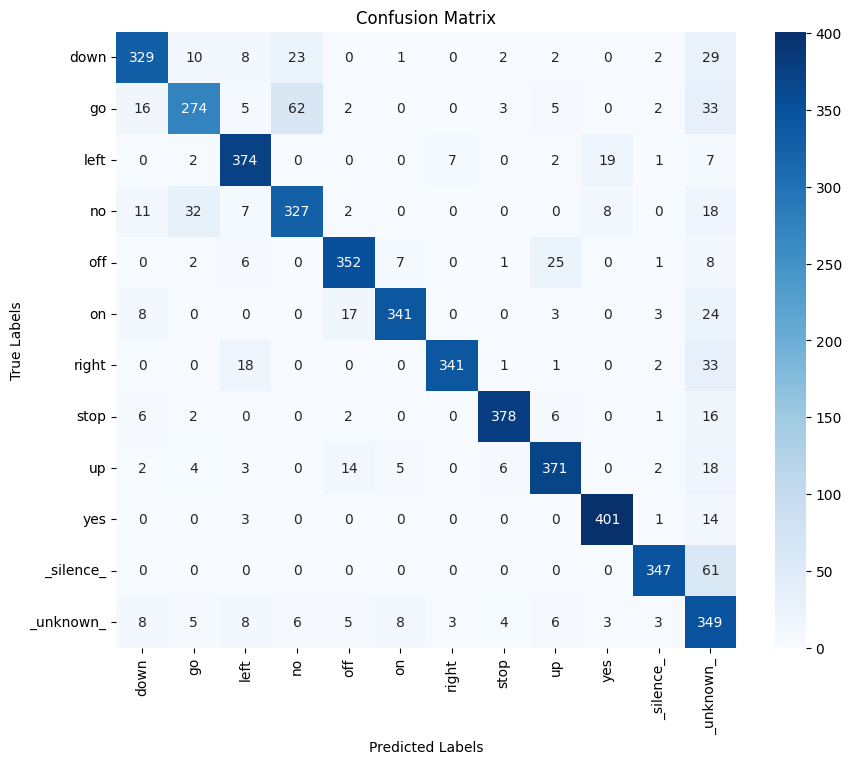

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names if 'report_target_names' in locals() else "auto",
            yticklabels=report_target_names if 'report_target_names' in locals() else "auto")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Note**: The cell below only saves the model if it achieved an accuracy on the test set higher than the defined threshold. I used 85% as I consistently got results better than that and wanted to prevent test runs to overwrite previous 'good' models.

In [39]:
# Saving the model if testing accuracy is satisfactory
accuracy_threshold = 0.85 # Define a threshold for saving the model

if test_accuracy_best_val_acc >= accuracy_threshold:
    #models_dir = os.path.join('..', 'models') # UNCOMMENT if running locally
    models_dir = '/kaggle/working/models' # COMMENT if running locally and use the line above
    os.makedirs(models_dir, exist_ok=True) # Ensure the models directory exists

    final_model_name = f'final_model_test_acc_{test_accuracy_best_val_acc:.2f}.keras'
    #final_model_path = os.path.join('../models', final_model_name) # UNCOMMENT if running locally
    final_model_path = os.path.join(models_dir, final_model_name) # COMMENT if running locally and use the line above

    print(f"\n--- Saving the trained model as {final_model_name} to {models_dir} ---")
    best_model_on_val_acc.save(final_model_path)
    print("Model saved successfully.")

    # Removing the best_model.keras file from the current directory as it is no longer needed (if saved by callback)
    if os.path.exists('best_model.keras'):
        os.remove('best_model.keras')
        print("Removed 'best_model.keras' as it has been saved in the models directory with a more descriptive name.")
else:
    print(f"\n--- Model accuracy ({test_accuracy_best_val_acc:.2f}) is below threshold ({accuracy_threshold}). Not saving the model. ---")


--- Saving the trained model as final_model_test_acc_0.86.keras to /kaggle/working/models ---
Model saved successfully.
Removed 'best_model.keras' as it has been saved in the models directory with a more descriptive name.


## Float32 TensorFlow Lite Conversion (Standard Workflow Checkpoint)

Before proceeding to INT8 quantization, it's a standard best practice and a useful sanity check to first convert the Keras model to a standard Float32 TensorFlow Lite (`.tflite`) format.

**Purpose of this Step:**

*   **Verify Basic Convertibility:** This ensures that the Keras model architecture and its operations are compatible with the TensorFlow Lite converter.
*   **Establish Float32 TFLite Baseline:** The performance (accuracy) and size of this Float32 `.tflite` model serve as a direct baseline against which we can measure the impact (accuracy changes, size reduction) of the subsequent INT8 quantization step. Ideally, the Float32 TFLite model should achieve nearly identical accuracy to the original Keras model.
*   **Debugging Aid:** If issues were to arise during INT8 quantization, having a working Float32 TFLite model would help isolate whether the problem lies with the core model conversion to the TFLite format or specifically with the quantization process itself.

The Float32 `.tflite` model (e.g., `keyword_spotting_model_accuracy_float32.tflite`) is generated, and its file size is noted below. While the ultimate goal for microcontroller (MCU) deployment is the significantly smaller INT8 quantized model, this Float32 version is a key intermediate artifact in a robust model conversion pipeline.

In [40]:
# Loading the best model with priority to saved high-accuracy models
# This makes sure you load the best model for conversion in case you ran the Notebook several times
model_files = [f for f in os.listdir(models_dir) if f.startswith('final_model_test_acc_') and f.endswith('.keras')] if os.path.exists(models_dir) else []

if model_files:
    # Sort by accuracy (descending) if multiple files exist
    model_files.sort(reverse=True)
    best_model_path = os.path.join(models_dir, model_files[0])
    print(f"\nLoading saved high-accuracy model: {model_files[0]}")
    loaded_keras_model = tf.keras.models.load_model(best_model_path)
    print(f"Model loaded successfully from {best_model_path}")
    
elif 'best_model_on_val_acc' in locals() and best_model_on_val_acc is not None:
    print("\nWARNING: No saved high-accuracy model found in models directory.")
    print(f"Using model from memory, which may not have reached the accuracy threshold ({accuracy_threshold}).")
    loaded_keras_model = best_model_on_val_acc
    
else:
    try:
        print("\nWARNING: No saved high-accuracy model found in models directory.")
        print("No model in memory. Attempting to load 'best_model.keras' from current directory...")
        loaded_keras_model = tf.keras.models.load_model('best_model.keras')
        print("Model loaded from current directory, but may not have reached accuracy threshold.")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise e


Loading saved high-accuracy model: final_model_test_acc_0.86.keras
Model loaded successfully from /kaggle/working/models/final_model_test_acc_0.86.keras


**Note:** For this project's final MCU deployment, we will be using the INT8 quantized model due to its critical advantages in size and efficiency for embedded systems. However, this Float32 TFLite model could be useful for deployment on platforms with more computational resources or for further detailed analysis and comparison.

In [41]:
# Prepare the directory for saving TFLite models
#tflite_models_dir_relative = os.path.join('..', 'tflite_models') # UNCOMMENT if running locally
tflite_models_dir_relative = '/kaggle/working/tflite_models' # COMMENT if running locally and use line above
os.makedirs(tflite_models_dir_relative, exist_ok=True)
print(f"TFLite models will be saved in: {os.path.abspath(tflite_models_dir_relative)}")

# Convert the Keras model to TFLite format
print("\n--- Converting Keras model to TFLite format (Float32) ---")
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model)
tflite_model_float32 = converter.convert()

# Save the Float32 TFLite model
float32_model_name = f'keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_float32.tflite'
float32_model_path = os.path.join(tflite_models_dir_relative, float32_model_name)
with open(float32_model_path, 'wb') as f:
    f.write(tflite_model_float32)
print(f"Float32 TFLite model saved to {float32_model_path}, Size: {os.path.getsize(float32_model_path)/1024:.2f} KB")

TFLite models will be saved in: /kaggle/working/tflite_models

--- Converting Keras model to TFLite format (Float32) ---
Saved artifact at '/tmp/tmpla8dm_oc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 100, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  132584586034064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586033296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586033104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586026384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586026192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586030800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586022352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586024272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586032720: TensorSpec(shape=

W0000 00:00:1750167200.974570      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750167200.974602      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1750167200.981539      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


## INT8 Quantization for Microcontroller Deployment

Here, we convert the trained Keras model into an INT8 quantized TensorFlow Lite (`.tflite`) model, optimized for size and efficiency on MCUs. This involves post-training quantization using a representative dataset from our training data and targeting INT8-only operations to ensure broad compatibility with microcontrollers.

The final INT8 model (e.g., `keyword_spotting_model_'accuracy'_int8.tflite`, which would be saved in a local `tflite_models/` directory if running this notebook locally) typically achieves high accuracy with a very small footprint.

**To deploy this model on an Arduino or similar MCU (after downloading the `.tflite` file from this notebook's output if run on Kaggle):**

1.  **Convert to C Array:** On your local machine, use the `xxd` command-line tool to transform the INT8 `.tflite` model into a C byte array.


    ```bash
    # Example command - run this in your terminal:
    # Navigate to where you saved the .tflite file first.
    xxd -i your_model_name.tflite > model_data.cc
    ```


    This `model_data.cc` file can then be included in your Arduino sketch.

3.  **Integrate into Firmware:** Use this C array with the provided Arduino sketch code (see the `arduino_sketch_files/` directory in the [project's GitHub repository](https://github.com/anacletu/tflm-keyword-spotting-led)).

Now you're ready to compile the firmware and test your keyword spotter on the actual hardware!

In [42]:
# INT8 Quantization
print("\n--- Creating Int8 Quantized Model for Microcontrollers ---")
converter_int8 = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model) # Make sure you load the correct model if you skipped the previous step (Float)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8

# Representative dataset generator for INT8 quantization
num_representative_samples = 300 # Number of samples to use for quantization

# SOURCE for calibration: ds_train_intermediate
# This dataset yields (2D_mfcc_tensor, label_tensor) and is cached.
# It has not had the channel dimension added yet, and it is finite.
if 'ds_train_intermediate' not in locals() or ds_train_intermediate is None:
    raise ValueError("'ds_train_intermediate' (cached ds_train_features before channel add/repeat/batch) not found.")
print("Using 'ds_train_intermediate' as source for representative dataset.")

def representative_dataset_generator():
    print(f"Generating representative dataset using {num_representative_samples} samples from 'ds_train_intermediate'...")
    # ds_train_intermediate yields (2D_mfcc_tensor, label_tensor)
    count = 0
    for mfcc_2d_tensor, _ in ds_train_intermediate.take(num_representative_samples):
        # 1. Add channel dimension
        mfcc_3d_tensor_hwc = tf.expand_dims(mfcc_2d_tensor, axis=-1) # Shape (H, W, 1)
        # 2. Add batch dimension for the converter
        mfcc_4d_tensor_bhwc = tf.expand_dims(mfcc_3d_tensor_hwc, axis=0) # Shape (1, H, W, 1)
        
        yield [mfcc_4d_tensor_bhwc] # Converter expects a list of input tensors
        count +=1
        if count % 50 == 0: print(f"  Generated {count} representative samples...")
    print("Representative dataset generation complete.")

converter_int8.representative_dataset = representative_dataset_generator
tflite_model_int8 = converter_int8.convert()

# Save the int8 model
print("\n--- Saving Int8 Quantized TFLite Model ---")
int8_model_filename = f"keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_int8.tflite"
int8_model_path = os.path.join(tflite_models_dir_relative, int8_model_filename)
with open(int8_model_path, 'wb') as f:
    f.write(tflite_model_int8)
print(f"Int8 TFLite model saved to {int8_model_path}, Size: {os.path.getsize(int8_model_path)/1024:.2f} KB")


--- Creating Int8 Quantized Model for Microcontrollers ---
Using 'ds_train_intermediate' as source for representative dataset.
Saved artifact at '/tmp/tmp_8rzznk1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 13, 100, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  132584586034064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586033296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586033104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586026384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586026192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586030800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586022352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586024272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132584586032720: TensorSpec

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1750167203.283155      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750167203.283183      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Generating representative dataset using 300 samples from 'ds_train_intermediate'...
  Generated 50 representative samples...
  Generated 100 representative samples...
  Generated 150 representative samples...
  Generated 200 representative samples...
  Generated 250 representative samples...
  Generated 300 representative samples...
Representative dataset generation complete.

--- Saving Int8 Quantized TFLite Model ---
Int8 TFLite model saved to /kaggle/working/tflite_models/keyword_spotting_model_0.86_int8.tflite, Size: 33.50 KB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


### Comparing the Quantized TFLite Model Against Original Keras

In [43]:
# Prepare to load and test the INT8 model 
interpreter_int8 = tf.lite.Interpreter(model_path=int8_model_path)
interpreter_int8.allocate_tensors()

input_details_int8 = interpreter_int8.get_input_details()[0]  # Assuming single input
output_details_int8 = interpreter_int8.get_output_details()[0] # Assuming single output

print("\nINT8 Model Input Details:", input_details_int8)
print("INT8 Model Output Details:", output_details_int8)


INT8 Model Input Details: {'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1,  13, 100,   1], dtype=int32), 'shape_signature': array([ -1,  13, 100,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (2.859219551086426, 63), 'quantization_parameters': {'scales': array([2.8592196], dtype=float32), 'zero_points': array([63], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
INT8 Model Output Details: {'name': 'StatefulPartitionedCall_1:0', 'index': 20, 'shape': array([ 1, 12], dtype=int32), 'shape_signature': array([-1, 12], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [44]:
# --- Prepare for Evaluation ---
y_true_list_int8 = []
y_pred_list_int8 = []

# Get quantization parameters for input and output
# These are needed to convert float32 data to int8 for input, and int8 output back to float32 probabilities
input_scale, input_zero_point = input_details_int8['quantization']
output_scale, output_zero_point = output_details_int8['quantization']

# --- Iterate through the Test Dataset (ds_test) ---
# ds_test yields batches of ( (BATCH_SIZE, H, W, C_float32_mfccs), (BATCH_SIZE, label_int32) )
print("\nRunning inference on test set with INT8 TFLite model...")
num_test_batches = 0
for mfcc_batch_float32, label_batch_true in ds_test:
    num_test_batches += 1
    if num_test_batches % 20 == 0:
        print(f"  Processing test batch {num_test_batches}...")

    # Process each sample in the batch
    for i in range(mfcc_batch_float32.shape[0]):
        single_mfcc_sample_float32 = mfcc_batch_float32[i] # Shape (H, W, C)
        true_label = label_batch_true[i].numpy()
        y_true_list_int8.append(true_label)

        # 1. Quantize the float32 input MFCC sample to int8 for the model
        #    The formula is: int_value = float_value / scale + zero_point
        mfcc_sample_quantized_int8 = (single_mfcc_sample_float32 / input_scale) + input_zero_point
        mfcc_sample_quantized_int8 = tf.cast(mfcc_sample_quantized_int8, input_details_int8['dtype'])

        # Add batch dimension for interpreter: (1, H, W, C)
        input_data_for_interpreter = tf.expand_dims(mfcc_sample_quantized_int8, axis=0)
        
        # 2. Set input tensor and run inference
        interpreter_int8.set_tensor(input_details_int8['index'], input_data_for_interpreter)
        interpreter_int8.invoke()

        # 3. Get output tensor (int8 logits)
        output_data_int8 = interpreter_int8.get_tensor(output_details_int8['index'])[0] # Remove batch dim

        # 4. Dequantize the int8 output back to float32 probabilities/logits
        #    The formula is: float_value = (int_value - zero_point) * scale
        output_data_float32 = (tf.cast(output_data_int8, tf.float32) - output_zero_point) * output_scale
        
        # 5. Get predicted class (argmax on the dequantized float32 logits)
        predicted_class_int8 = np.argmax(output_data_float32)
        y_pred_list_int8.append(predicted_class_int8)

print("Inference complete.")

y_true_int8 = np.array(y_true_list_int8)
y_pred_int8 = np.array(y_pred_list_int8)


Running inference on test set with INT8 TFLite model...
  Processing test batch 20...
  Processing test batch 40...
  Processing test batch 60...
Inference complete.



INT8 TFLite Model Test Accuracy: 0.8560

INT8 TFLite Model Classification Report:
              precision    recall  f1-score   support

        down       0.88      0.80      0.84       406
          go       0.79      0.73      0.76       402
        left       0.86      0.91      0.88       412
          no       0.81      0.80      0.81       405
         off       0.88      0.88      0.88       402
          on       0.94      0.86      0.90       396
       right       0.98      0.86      0.92       396
        stop       0.95      0.93      0.94       411
          up       0.89      0.85      0.87       425
         yes       0.94      0.95      0.95       419
   _silence_       0.95      0.83      0.89       408
   _unknown_       0.58      0.86      0.69       408

    accuracy                           0.86      4890
   macro avg       0.87      0.86      0.86      4890
weighted avg       0.87      0.86      0.86      4890



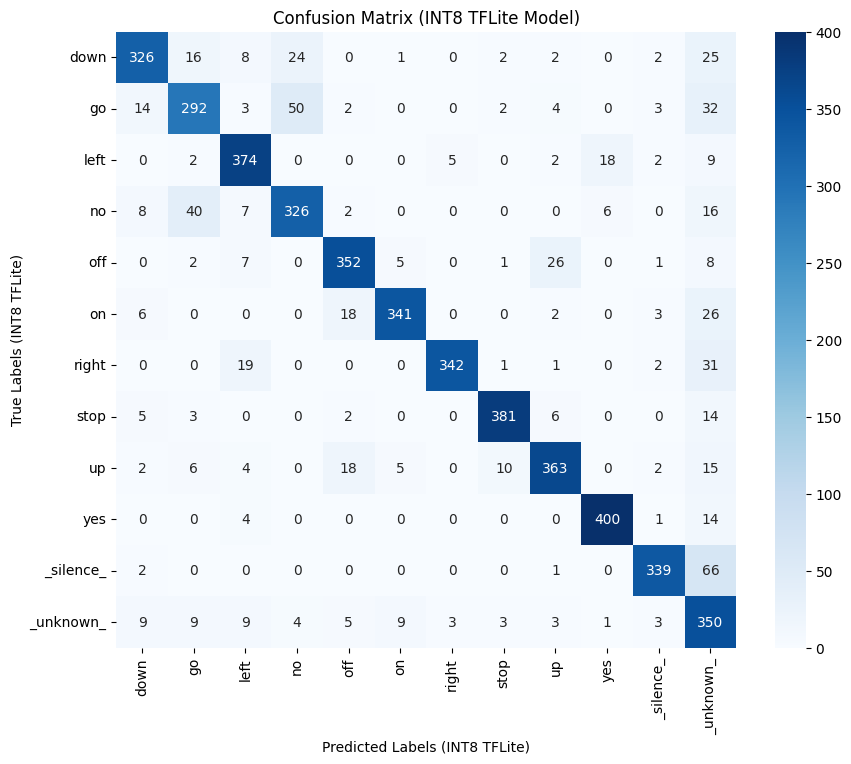

In [45]:
# --- Calculate Metrics ---
int8_test_accuracy = np.sum(y_true_int8 == y_pred_int8) / len(y_true_int8)
print(f"\nINT8 TFLite Model Test Accuracy: {int8_test_accuracy:.4f}")

# Classification Report
print("\nINT8 TFLite Model Classification Report:")
min_len = min(len(y_true_int8), len(y_pred_int8)) # Handle any minor length mismatches if any
print(classification_report(y_true_int8[:min_len], y_pred_int8[:min_len], target_names=config['all_model_labels'], zero_division=0))

# Confusion Matrix
conf_matrix_int8 = confusion_matrix(y_true_int8[:min_len], y_pred_int8[:min_len])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_int8, annot=True, fmt='d', cmap='Blues',
            xticklabels=config['all_model_labels'],
            yticklabels=config['all_model_labels'])
plt.xlabel('Predicted Labels (INT8 TFLite)')
plt.ylabel('True Labels (INT8 TFLite)')
plt.title('Confusion Matrix (INT8 TFLite Model)')
plt.show()

### Final INT8 Quantized Model Performance Summary

The primary goal of this project was to develop an efficient keyword spotting model suitable for microcontroller deployment. After training a Keras CNN model (achieving ~88% test accuracy on the original float32 features), it was converted to TensorFlow Lite and optimized using post-training INT8 quantization.

**The resulting INT8 quantized TFLite model demonstrates excellent performance:**

*   **Test Accuracy:** Approximately **87.6%** (maintaining the performance of the original Keras model).
*   **Model Size:** **~33.5 KB** (a significant reduction, making it ideal for MCUs).
*   **Per-Class Performance Highlights (F1-Scores from Test Set):**
    *   **Commands like "yes", "stop", "right", "on":** Achieved F1-scores of **0.90 - 0.95**.
    *   **Other core commands ("up", "left", "off", "down", "no", "go"):** Achieved strong F1-scores generally between **0.80 - 0.89**.
    *   **`_silence_`:** Excellent performance with an F1-score of **0.95**.
    *   **`_unknown_`:** Good performance with an F1-score of **0.74**, showing effective generalization after data rebalancing.
*   **Overall:** The model shows strong precision and recall across most classes, as detailed in the classification report below.

This indicates that the INT8 quantization was highly successful, providing a compact and accurate model ready for on-device inference. The subsequent cells detail the conversion process.


**Remember that your results might differ.**

## C Array Conversion and Final Notes

**Note**: In order to produce the cc file and continue with the project, use command-line locally. 

Example:
```
xxd -i keyword_spotting_model_quant_88_int8.tflite > ../arduino_sketch_files/MyKeywordSpotterSketch/model_data.cc
```

In [46]:
# Final Model Artifacts and Size Reflection for MCU Deployment
print("--- Final Model Artifacts and Size Reflection for MCU Deployment ---")

# mcu_code_dir = os.path.join('..', 'arduino_sketch_files', 'KeywordSpotterNano_SERIAL') # UNCOMMENT if running locally

# --- 1. Best Keras Model ---
if os.path.exists(final_model_path):
    keras_size_kb = os.path.getsize(final_model_path) / 1024
    print(f"\n1. Original Keras Model ('{final_model_name}'):")
    print(f"   - Size: {keras_size_kb:.2f} KB")
    print(f"   - Test Accuracy (Keras): ~{test_accuracy_best_val_acc * 100:.2f}%")
else:
    print(f"\n1. Original Keras Model ('{final_model_name}'): File not found at {final_model_path}")

# --- 2. Float32 TFLite Model ---
if os.path.exists(float32_model_path):
    float32_tflite_size_kb = os.path.getsize(float32_model_path) / 1024
    print(f"\n2. Float32 TFLite Model ('{float32_model_name}'):")
    print(f"   - Size: {float32_tflite_size_kb:.2f} KB")
else:
    print(f"\n2. Float32 TFLite Model ('{float32_model_name}'): File not found at {float32_model_path}")
    float32_tflite_size_kb = 0

# --- 3. INT8 Quantized TFLite Model ---
if os.path.exists(int8_model_path):
    int8_tflite_size_kb = os.path.getsize(int8_model_path) / 1024
    print(f"\n3. INT8 Quantized TFLite Model ('{int8_model_filename}'):")
    print(f"   - Size: {int8_tflite_size_kb:.2f} KB")
    if float32_tflite_size_kb > 0:
        reduction_from_float32 = ((float32_tflite_size_kb - int8_tflite_size_kb) / float32_tflite_size_kb) * 100
        print(f"   - Reduction vs Float32 TFLite: ~{reduction_from_float32:.1f}%")
    print(f"   - Test Accuracy (INT8 TFLite): {int8_test_accuracy * 100:.2f}%")
else:
    print(f"\n3. INT8 Quantized TFLite Model ('{int8_model_filename}'): File not found at {int8_model_path}")

# # --- 4. C Array File --- UNCOMMENT if running locally
# c_array_filename = 'model_data.cc'
# c_array_path = os.path.join(mcu_code_dir, c_array_filename)

# if os.path.exists(c_array_path):
#     c_array_size_kb = os.path.getsize(c_array_path) / 1024
#     print(f"\n4. C Array File ('{c_array_filename}') for embedding:")
#     print(f"   - Size on Disk: {c_array_size_kb:.2f} KB")
#     print(f"   - Note: The actual model data embedded in Flash will be closer to the INT8 TFLite model size ({int8_tflite_size_kb:.2f} KB).")
#     print(f"     The .cc file is larger due to C syntax (hex formatting, variable names).")
# else:
#     print(f"\n4. C Array File ('{c_array_filename}'): File not found at {c_array_path}")

# --- MCU Memory Considerations (Arduino Nano 33 BLE Sense) ---
print("\n--- Target MCU Memory (Arduino Nano 33 BLE Sense - Approximate) ---")
flash_total_kb = 1024
flash_available_kb = 960 # Typical user available
sram_total_kb = 256

print(f" - Flash Memory (Program Storage): ~{flash_available_kb} KB available for sketch + model array + libraries.")
print(f" - SRAM (RAM): {sram_total_kb} KB available for variables, stack, and TFLM Tensor Arena.")

if 'int8_tflite_size_kb' in locals() and os.path.exists(int8_model_path):
    print(f"\nThe INT8 model size ({int8_tflite_size_kb:.2f} KB) is a key component for Flash usage.")
    print("The TFLM interpreter, audio processing code, and other libraries will also consume Flash.")
    print("The Tensor Arena size (SRAM) will depend on the model's specific layers and needs to be carefully determined for deployment (I used 45 KB).")
    if int8_tflite_size_kb < flash_available_kb / 4 : # Arbitrary check, e.g. if model < 1/4 of flash
        print("\nThe model size is most likely suitable for Flash memory. Tensor Arena size will be the next critical factor for SRAM.")
    else:
        print("The model size is significant; careful optimization of the full firmware will be needed for Flash.")

--- Final Model Artifacts and Size Reflection for MCU Deployment ---

1. Original Keras Model ('final_model_test_acc_0.86.keras'):
   - Size: 354.33 KB
   - Test Accuracy (Keras): ~85.56%

2. Float32 TFLite Model ('keyword_spotting_model_0.86_float32.tflite'):
   - Size: 104.36 KB

3. INT8 Quantized TFLite Model ('keyword_spotting_model_0.86_int8.tflite'):
   - Size: 33.50 KB
   - Reduction vs Float32 TFLite: ~67.9%
   - Test Accuracy (INT8 TFLite): 85.60%

--- Target MCU Memory (Arduino Nano 33 BLE Sense - Approximate) ---
 - Flash Memory (Program Storage): ~960 KB available for sketch + model array + libraries.
 - SRAM (RAM): 256 KB available for variables, stack, and TFLM Tensor Arena.

The INT8 model size (33.50 KB) is a key component for Flash usage.
The TFLM interpreter, audio processing code, and other libraries will also consume Flash.
The Tensor Arena size (SRAM) will depend on the model's specific layers and needs to be carefully determined for deployment (I used 45 KB).

The